In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sgkit as sg
import json
import hashlib
import itertools as it


import allel; print('scikit-allel', allel.__version__)


scikit-allel 1.3.13


In [3]:
#px config
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 700,
    'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

#palettes
pop_code_cols = {
    'SAE' : '#6a3d9a', #dark purple
    'SAR' : '#cab2d6', #ligher purple
    'INB' : '#96172e', #darkred
    'INM' : '#f03e5e', #lightred
    'APA' : '#ff7f00', #orange
    'IRN' : '#C2907A', #not sure yet
    'DJI' : '#507d2a', #sap green
    'ETW' : '#a6cee3',#cerulean
    'ETB' : '#007272', #cobalt turq
    'ETS' : '#33a02c',#green
    'SUD' : '#fccf86',#ochre
    'YEM' : '#CC7722'#pinkish
}

#load and filter metadata
#load and filter metadata
df_samples = pd.read_csv('/Users/dennistpw/Projects/AsGARD/metadata/cease_combinedmetadata_noqc.20250212.csv')


In [4]:
# Initialize an empty dictionary to store row indices for each level
pop_dict = {}

# Iterate through unique levels in the 'factor_column'
for pop in df_samples['pop_code'].unique():
    pop_dict[pop] = df_samples.index[df_samples['pop_code'] == pop].tolist()

# Remove dictionary entries with fewer than 5 values
pop_dict = {key: value for key, value in pop_dict.items() if len(value) >= 5}

#get all pops too
#pop_dict['all'] = df_samples.index.tolist()


In [5]:
def hash_params(*args, **kwargs):
    """Helper function to hash analysis parameters."""
    o = {
        'args': args,
        'kwargs': kwargs
    }
    s = json.dumps(o, sort_keys=True).encode()
    h = hashlib.md5(s).hexdigest()
    return h

#function for getting allele counts
def snp_allele_counts(
    #gets all allele counts for a given chrom

        ds=None,
        sample_query=None,
        sample_list=None,
        min_ac=1
        ):
     
    if sample_query:
        loc_samples_a = df_samples.eval(sample_query).values
        ds = ds.isel(samples=loc_samples_a)
    elif sample_list:
        loc_samples_a = df_samples['sample_id'].isin(sample_list)
        ds = ds.isel(samples=loc_samples_a)

    ac = allel.GenotypeArray(ds.call_genotype.values).count_alleles()

    #need to make maf filter
    #if min_ac

    return ac

def do_fst_scan(
          chrom=None,
          sample_query_a=None, 
          sample_query_b=None,
          sample_list_a = None,
          sample_list_b=None,
          winsize=10000,
          analysis_name = 'fst',
          results_dir=None
    ):
            # construct a key to save the results under
    results_key = hash_params(
        chrom=chrom,
        sample_query_a=sample_query_a, 
        sample_query_b=sample_query_b,
        sample_list_a = sample_list_a,
        sample_list_b=sample_list_b, 
        winsize=winsize,
        analysis_name = analysis_name,
        results_dir=results_dir
        )

        # define paths for results files
    data_path = f'{results_dir}/{results_key}-fst.csv'

    try:
        # try to load previously generated results
        data = pd.read_csv(data_path)
        return data
    except FileNotFoundError:
        # no previous results available, need to run analysis
        print(f'running analysis: {results_key}')

    print('setting up inputs')

    #load ds
    ds = sg.load_dataset(f'/Users/dennistpw/Projects/AsGARD/data/variants_combined_cohorts/combined_cohorts.{chrom}.zarr')

    # Get accessible only
    print("Subsetting to accessible sites only")
    accmask = ds['is_accessible'].compute()
    ds = ds.sel(variants=(accmask))

    #get allele counts for a
    if sample_query_a:
        ac1 = snp_allele_counts(ds, sample_query = sample_query_a)
    else:
        ac1 = snp_allele_counts(ds, sample_list = sample_list_a)

    #get ac for b
    if sample_query_a:
        ac2 = snp_allele_counts(ds, sample_query = sample_query_b)
    else:
        ac2 = snp_allele_counts(ds, sample_list = sample_list_b)
    
    #get pos
    pos = ds.variant_position.values

    print("computing Fst")
    fst = allel.moving_hudson_fst(ac1, ac2, size=winsize)
    # Sometimes Fst can be very slightly below zero, clip for simplicity.
    fst = np.clip(fst, a_min=0, a_max=1)
    x = allel.moving_statistic(pos, statistic=np.mean, size=winsize)

    # save results
    fstdf = pd.DataFrame(
            {'chrom' : chrom,
            'midpos':x,
            'fst':fst})

    fstdf.to_csv(data_path, index=False)
    print(f'saved results: {results_key}')

    return(fstdf)



In [6]:
def do_fst_av(
          chrom=None,
          sample_query_a=None, 
          sample_query_b=None,
          sample_list_a = None,
          sample_list_b=None,
          winsize=10000,
          analysis_name = 'fst_average',
          results_dir=None
    ):
            # construct a key to save the results under
    results_key = hash_params(
        chrom=chrom,
        sample_query_a=sample_query_a, 
        sample_query_b=sample_query_b,
        sample_list_a = sample_list_a,
        sample_list_b=sample_list_b, 
        winsize=winsize,
        analysis_name = analysis_name,
        results_dir=results_dir
        )

        # define paths for results files
    data_path = f'{results_dir}/{results_key}-fst.csv'

    try:
        # try to load previously generated results
        data = pd.read_csv(data_path)
        return data
    except FileNotFoundError:
        # no previous results available, need to run analysis
        print(f'running analysis: {results_key}')

    print('setting up inputs')

    #load ds
    ds = sg.load_dataset(f'/Users/dennistpw/Projects/AsGARD/data/variants_combined_cohorts/combined_cohorts.{chrom}.zarr')

    #get allele counts for a
    if sample_query_a:
        ac1 = snp_allele_counts(ds, sample_query = sample_query_a)
    else:
        ac1 = snp_allele_counts(ds, sample_list = sample_list_a)

    #get ac for b
    if sample_query_a:
        ac2 = snp_allele_counts(ds, sample_query = sample_query_b)
    else:
        ac2 = snp_allele_counts(ds, sample_list = sample_list_b)
    
    #get pos
    pos = ds.variant_position.values

    print("allele counts and pos loaded")

    print("computing average Hudson Fst")
    fst = allel.average_hudson_fst(ac1, ac2, blen=winsize)


    fdict = {'fst':fst[0],'se':fst[1]}
    fstdf = pd.DataFrame([fdict])

    fstdf.to_csv(data_path, index=False)
    print(f'saved results: {results_key}')

    return(fstdf)



In [4]:
#define shaded regions
# Define shaded region x values

#chr2
cyp6_start = 67473117
cyp6_end = 67501071

ace1_start = 60916071
ace1_end = 60917000



#chr3
vgsc_start = 42817709
vgsc_end = 42817800

gste_start = 70572788
gste_end = 70584603


#chrx
cyp9k1_start = 9721225
cyp9k1_end = 9722225



In [8]:
fstlist = []
winsize=10000
output = '/Users/dennistpw/Projects/AsGARD/data/fst_20240712'

for chrom in ['CM023248','CM023249','CM023250']:
    for popa, popb in it.combinations(df_samples.pop_code.unique(),2):
        
        fst_df = do_fst_av(
            chrom = chrom,
            sample_query_a = f'pop_code == "{popa}"',
            sample_query_b = f'pop_code == "{popb}"',
            results_dir = output,
            analysis_name=f'{chrom}.{winsize}.{popa}.{popb}'
        )

        fst_df['popa'] = popa
        fst_df['popb'] = popb

        fstlist.append(fst_df)

    
fst_bigdf  = pd.concat(fstlist)

fst_bigdf['comp'] = fst_bigdf['popa'] +'_' + fst_bigdf['popb']

from matplotlib.gridspec import GridSpec

max_values = fst_bigdf.groupby('chrom')['midpos'].max()
total_max = max_values.sum()
column_widths = (max_values / total_max).values
col_var_levels = max_values.index
    
cyp6_region = {'CM023248': {'x_min': 67473117, 'x_max': 67501071, 'y_min': 0, 'y_max': 1}}
ace1_region = {'CM023248': {'x_min': 60916071, 'x_max': 60917000, 'y_min': 0, 'y_max': 1}}
vgsc_region = {'CM023249': {'x_min': 42817709, 'x_max': 42817800, 'y_min': 0, 'y_max': 1}}
gste_region = {'CM023249': {'x_min': 70572788, 'x_max': 70584603, 'y_min': 0, 'y_max': 1}}
carboxylesterase_region = {'CM023249':{'x_min' : 18816120, 'x_max' :18816120, 'y_min': 0, 'y_max': 1}}
cyp9_region = {'CM023250': {'x_min': 9721225, 'x_max': 9722225, 'y_min': 0, 'y_max': 1}}
diagk = {'CM023250': {'x_min': 4578144, 'x_max': 4578144, 'y_min': 0, 'y_max': 1}}




running analysis: c5eb1521508b54db9c49e7c16ca78db5
setting up inputs
allele counts and pos loaded
computing average Hudson Fst
saved results: c5eb1521508b54db9c49e7c16ca78db5
running analysis: 44c19d1484670cbc020b9bcc6281987b
setting up inputs
allele counts and pos loaded
computing average Hudson Fst
saved results: 44c19d1484670cbc020b9bcc6281987b
running analysis: 8990e4a25cb661dc7049414891fc8757
setting up inputs


KeyboardInterrupt: 

In [25]:
len(fst_bigdf['comp'].unique())

45

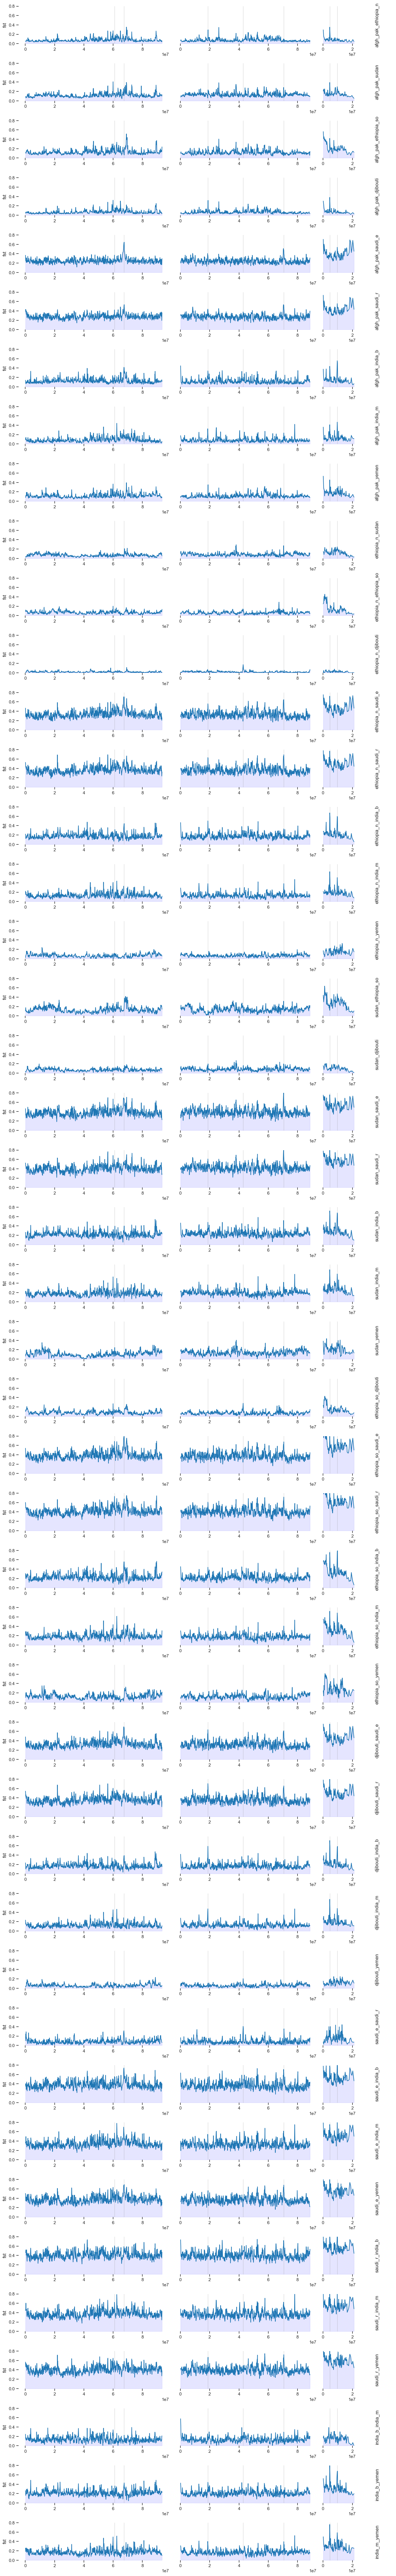

In [22]:
# Get the unique row and column variables
row_var_levels = fst_bigdf['comp'].unique()

# Initialize the figure and GridSpec
fig = plt.figure(figsize=(sum(column_widths) * 14, len(row_var_levels) * 2))  # Plots half as high
gs = GridSpec(len(row_var_levels), len(col_var_levels) + 1, width_ratios=list(column_widths) + [0.1])

# Create the subplots
for row_idx, row_val in enumerate(row_var_levels):
    for col_idx, col_val in enumerate(col_var_levels):
        ax = fig.add_subplot(gs[row_idx, col_idx])
        subset = fst_bigdf[(fst_bigdf['comp'] == row_val) & (fst_bigdf['chrom'] == col_val)]
        sns.lineplot(data=subset, x='midpos', y='fst', ax=ax)

        ax.fill_between(x=subset['midpos'], y1=subset['fst'], color='blue', alpha=0.1)  # Adjust alpha for transparency if needed

        #ax.set_title(f"{row_val} - {col_val}")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        # Remove y-axis for 2nd and 3rd columns
        if col_idx > 0:
            ax.set_ylabel('')
            ax.yaxis.set_visible(False)

        if col_val == 'CM023248':
            ax.fill_betweenx([cyp6_region[col_val]['y_min'], cyp6_region[col_val]['y_max']],
                            cyp6_region[col_val]['x_min'], cyp6_region[col_val]['x_max'],
                            color='gray', alpha=0.3)
            ax.fill_betweenx([ace1_region[col_val]['y_min'], ace1_region[col_val]['y_max']],
                            ace1_region[col_val]['x_min'], ace1_region[col_val]['x_max'],
                            color='gray', alpha=0.3)
        elif col_val == 'CM023249':
            ax.fill_betweenx([vgsc_region[col_val]['y_min'], vgsc_region[col_val]['y_max']],
                            vgsc_region[col_val]['x_min'], vgsc_region[col_val]['x_max'],
                            color='gray', alpha=0.3)
            ax.fill_betweenx([gste_region[col_val]['y_min'], gste_region[col_val]['y_max']],
                            gste_region[col_val]['x_min'], gste_region[col_val]['x_max'],
                            color='gray', alpha=0.3)
            ax.fill_betweenx([carboxylesterase_region[col_val]['y_min'], carboxylesterase_region[col_val]['y_max']],
                            carboxylesterase_region[col_val]['x_min'], carboxylesterase_region[col_val]['x_max'],
                            color='gray', alpha=0.3)
        elif col_val == 'CM023250':
            ax.fill_betweenx([cyp9_region[col_val]['y_min'], cyp9_region[col_val]['y_max']],
                            cyp9_region[col_val]['x_min'], cyp9_region[col_val]['x_max'],
                            color='gray', alpha=0.3)
            ax.fill_betweenx([diagk[col_val]['y_min'], diagk[col_val]['y_max']],
                            diagk[col_val]['x_min'], diagk[col_val]['x_max'],
                            color='gray', alpha=0.3)

        

        # Remove x-axis
        ax.set_xlabel('')
        #ax.xaxis.set_visible(False)

        ax.set_ylim(0, 0.8)

        
    # Add the row title
    row_ax = fig.add_subplot(gs[row_idx, -1])
    row_ax.text(0.5, 0.5, row_val, va='center', ha='center', fontsize=12, rotation=90, transform=row_ax.transAxes)
    row_ax.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.01)  # Reduce column and row padding
plt.tight_layout()
plt.show()
fig.savefig('../figures/fstscan.svg')


In [13]:
fstlist = []
winsize=10000
output = '/Users/dennistpw/Projects/AsGARD/data/fst_20240712'

for chrom in ['CM023248','CM023249','CM023250']:
    for popa, popb in it.combinations(['afgh_pak','djibouti','saudi_e'],2):
        
        fst_df = do_fst_scan(
            chrom = chrom,
            sample_query_a = f'analysis_pop == "{popa}"',
            sample_query_b = f'analysis_pop == "{popb}"',
            results_dir = output,
            analysis_name=f'{chrom}.{winsize}.{popa}.{popb}'
        )

        fst_df['popa'] = popa
        fst_df['popb'] = popb

        fstlist.append(fst_df)

    
fst_bigdf  = pd.concat(fstlist)
fst_bigdf['comp'] = fst_bigdf['popa'] +':' + fst_bigdf['popb']


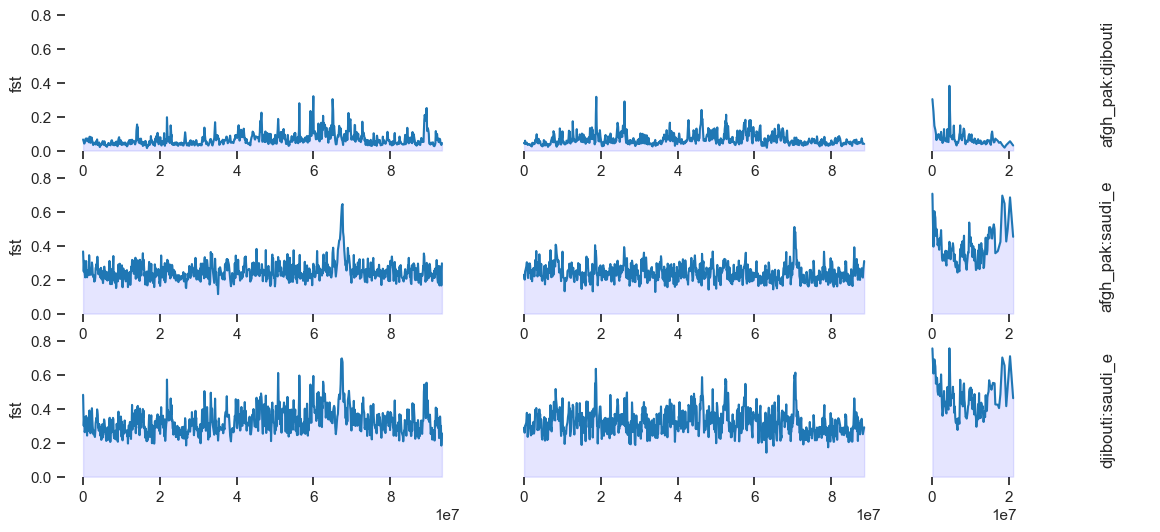

In [18]:
from matplotlib.gridspec import GridSpec

max_values = fst_bigdf.groupby('chrom')['midpos'].max()
total_max = max_values.sum()
column_widths = (max_values / total_max).values
col_var_levels = max_values.index
# Get the unique row and column variables
row_var_levels = fst_bigdf['comp'].unique()

# Initialize the figure and GridSpec
fig = plt.figure(figsize=(sum(column_widths) * 14, len(row_var_levels) * 2))  # Plots half as high
gs = GridSpec(len(row_var_levels), len(col_var_levels) + 1, width_ratios=list(column_widths) + [0.1])

# Create the subplots
for row_idx, row_val in enumerate(row_var_levels):
    for col_idx, col_val in enumerate(col_var_levels):
        ax = fig.add_subplot(gs[row_idx, col_idx])
        subset = fst_bigdf[(fst_bigdf['comp'] == row_val) & (fst_bigdf['chrom'] == col_val)]
        sns.lineplot(data=subset, x='midpos', y='fst', ax=ax)

        ax.fill_between(x=subset['midpos'], y1=subset['fst'], color='blue', alpha=0.1)  # Adjust alpha for transparency if needed

        #ax.set_title(f"{row_val} - {col_val}")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)


        # Remove x-axis
        ax.set_xlabel('')
        #ax.xaxis.set_visible(False)

        ax.set_ylim(0, 0.8)

        if col_idx > 0:
            ax.set_ylabel('')
            ax.yaxis.set_visible(False)
    # Add the row title
    row_ax = fig.add_subplot(gs[row_idx, -1])
    row_ax.text(0.5, 0.5, row_val, va='center', ha='center', fontsize=12, rotation=90, transform=row_ax.transAxes)
    row_ax.axis('off')
plt.savefig('fst_foreric.pdf')

In [7]:
fstlist = []
winsize=10000
output = '/Users/dennistpw/Projects/AsGARD/data/fst_20240712'

for chrom in ['CM023248','CM023249','CM023250']:
    for popa, popb in it.combinations(df_samples.pop_code.unique(),2):
        
        hud_fst_df = do_fst_av(
            chrom = chrom,
            sample_query_a = f'pop_code == "{popa}"',
            sample_query_b = f'pop_code == "{popb}"',
            results_dir = output,
            #analysis_name=f'{chrom}.{winsize}.{popa}.{popb}.hudfst'
        )

        hud_fst_df['popa'] = popa
        hud_fst_df['popb'] = popb
        hud_fst_df['chrom'] = chrom

        fstlist.append(hud_fst_df)

running analysis: abd50017bd83f6c8c48536a45cb2f47c
setting up inputs
allele counts and pos loaded
computing average Hudson Fst
saved results: abd50017bd83f6c8c48536a45cb2f47c
running analysis: cfca5a83c740d0b65cd2d96387a238fb
setting up inputs
allele counts and pos loaded
computing average Hudson Fst
saved results: cfca5a83c740d0b65cd2d96387a238fb
running analysis: c06438d1ebb85696d127645307cba259
setting up inputs
allele counts and pos loaded
computing average Hudson Fst
saved results: c06438d1ebb85696d127645307cba259
running analysis: 6bef003ca72ee7ff1c11c3a7f6523a0a
setting up inputs
allele counts and pos loaded
computing average Hudson Fst
saved results: 6bef003ca72ee7ff1c11c3a7f6523a0a
running analysis: 9c484706a83519ebed93bb8332fe5f9a
setting up inputs
allele counts and pos loaded
computing average Hudson Fst
saved results: 9c484706a83519ebed93bb8332fe5f9a
running analysis: f51cff9e6bc458aff16dafc42cc7605b
setting up inputs
allele counts and pos loaded
computing average Hudson Fs

In [8]:
fst_hud_df = pd.concat(fstlist)
sub = fst_hud_df[fst_hud_df['chrom'] == 'CM023248']
sub2 = sub.copy()

In [9]:
order = list(pop_code_cols.keys())
order.reverse()


In [12]:
order = ['YEM',
 'SUD',
 'ETS',
 'ETB',
 'ETW',
 'DJI',
 'INM',
 'INB',
 'APA',
 'IRS',
 'IRH',
 'SAR',
 'SAE']

<Figure size 800x600 with 0 Axes>

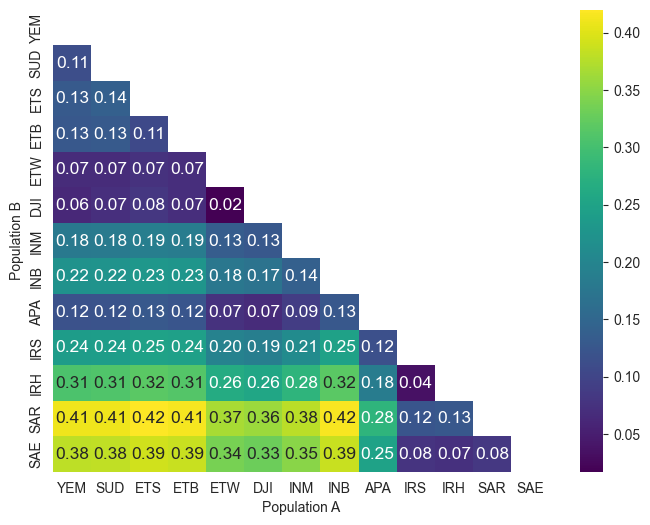

In [13]:
sub2.columns = ['fst', 'se', 'popb', 'popa', 'chrom']
subc=pd.concat([sub,sub2])
pivot_df = subc.pivot(index="popa", columns="popb", values="fst")

#reorder df

reordered_df = pivot_df.loc[order, order]

# Create a mask for the lower triangle
mask = np.triu(np.ones_like(reordered_df, dtype=bool))
sns.set_style('white')

# Plot the heatmap with the mask
plt.figure(figsize=(8, 6))
# Plot the heatmap with the mask
plt.figure(figsize=(8, 6))
hm = sns.heatmap(
    reordered_df,
    mask=mask,
    cmap='viridis',  # Use viridis color palette
    annot=True,
    cbar=True,
    fmt=".2f",
    annot_kws={"size": 12.5}
)

# Customize axis labels
hm.set_xlabel('Population A')
hm.set_ylabel('Population B')
plt.savefig('../figures/fst_heatmap.svg')
plt.savefig('../figures/fst_heatmap.png')

In [23]:
pivot_df = subc.pivot(index="popa", columns="popb", values="fst")

# Fill missing values in the upper triangle with values from the lower triangle
pivot_df = pivot_df.fillna(0)

# Convert to numpy array for easier manipulation
matrix = pivot_df.values

# Create a symmetric matrix by mirroring the lower triangle to the upper triangle
symmetric_matrix = np.maximum(matrix, matrix.T)

# Convert back to DataFrame
symmetric_df = pd.DataFrame(symmetric_matrix, index=pivot_df.index, columns=pivot_df.columns)



In [45]:
loc_groups = df_samples.query('country != "Pakistan" & country != "Afghanistan" & country != "SaudiArabia" & country != "India"').groupby('location').count()
locs = loc_groups['sample_id'][loc_groups['sample_id'] > 5].index.tolist()
locs
#cheap manual reorder
locs = ['Nangarhar','DjiboutiCity','AdenCity','Dubti','Jiga','Modjo','Babile','KebriDehar','Danan','PortSudan','Haiya','AlShukria','EastElglabat','ElZedab','SouthShandi','GeziraIslang','Arkaweet','ElSalamaniaWest','ElMeaileg','Wafara','AlGalaa','Agaja']


In [47]:
#Let's quickly calculate Fst here by location, in locs with > 10 samples, to infer potential isoBD
fstlist = []
winsize=10000
output = '/Users/dennistpw/Projects/AsGARD/data/fst_byloc/'

for chrom in ['CM023248','CM023249','CM023250']:
    for popa, popb in it.combinations(locs,2):
        
        hud_fst_df = do_fst_av(
            chrom = chrom,
            sample_query_a = f'location == "{popa}"',
            sample_query_b = f'location == "{popb}"',
            results_dir = output,
            analysis_name=f'{chrom}.{winsize}.{popa}.{popb}.hudfst'
        )

        hud_fst_df['loca'] = popa
        hud_fst_df['locb'] = popb
        hud_fst_df['chrom'] = chrom

        fstlist.append(hud_fst_df)

running analysis: d1f3a45b1a3d0df933fce8500bba0927
setting up inputs
allele counts and pos loaded
computing average Hudson Fst
saved results: d1f3a45b1a3d0df933fce8500bba0927
running analysis: 2e1372d27336e61b97792c8e330f73b7
setting up inputs
allele counts and pos loaded
computing average Hudson Fst
saved results: 2e1372d27336e61b97792c8e330f73b7
running analysis: c5f8434a4882a1a74c08fcc4a50d9d61
setting up inputs
allele counts and pos loaded
computing average Hudson Fst
saved results: c5f8434a4882a1a74c08fcc4a50d9d61
running analysis: 9705eba73f010ee70e4a1d5fdc075bdf
setting up inputs
allele counts and pos loaded
computing average Hudson Fst
saved results: 9705eba73f010ee70e4a1d5fdc075bdf
running analysis: 8622170580e9f0e9bc6832a3a7cee092
setting up inputs
allele counts and pos loaded
computing average Hudson Fst
saved results: 8622170580e9f0e9bc6832a3a7cee092
running analysis: ce17eee785bc4586c58dd825ab08b6b2
setting up inputs
allele counts and pos loaded
computing average Hudson Fs

In [48]:
fst_hud_df = pd.concat(fstlist)
sub = fst_hud_df[fst_hud_df['chrom'] == 'CM023248']
sub2 = sub.copy()
sub2



sub.columns = ['fst', 'se', 'popb', 'popa', 'chrom']
subc=pd.concat([sub,sub2])
pivot_df = sub.pivot(index="popa", columns="popb", values="fst")

#reorder df

reordered_df = pivot_df.loc[locs, locs]

# Create a mask for the lower triangle
mask = np.triu(np.ones_like(reordered_df, dtype=bool))

# Plot the heatmap with the mask
plt.figure(figsize=(8, 6))
# Plot the heatmap with the mask
plt.figure(figsize=(8, 6))
hm = sns.heatmap(
    reordered_df,
    mask=mask,
    cmap='viridis',  # Use viridis color palette
    annot=True,
    cbar=True
)

# Customize axis labels
hm.set_xlabel('Population A')
hm.set_ylabel('Population B')
plt.savefig('../figures/fst_heatmap.svg')
plt.savefig('../figures/fst_heatmap.tiff')

KeyError: "['Nangarhar'] not in index"

/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_31300/3377019639.py:5: FutureWarning:

The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.



Text(120.72222222222221, 0.5, 'Population B')

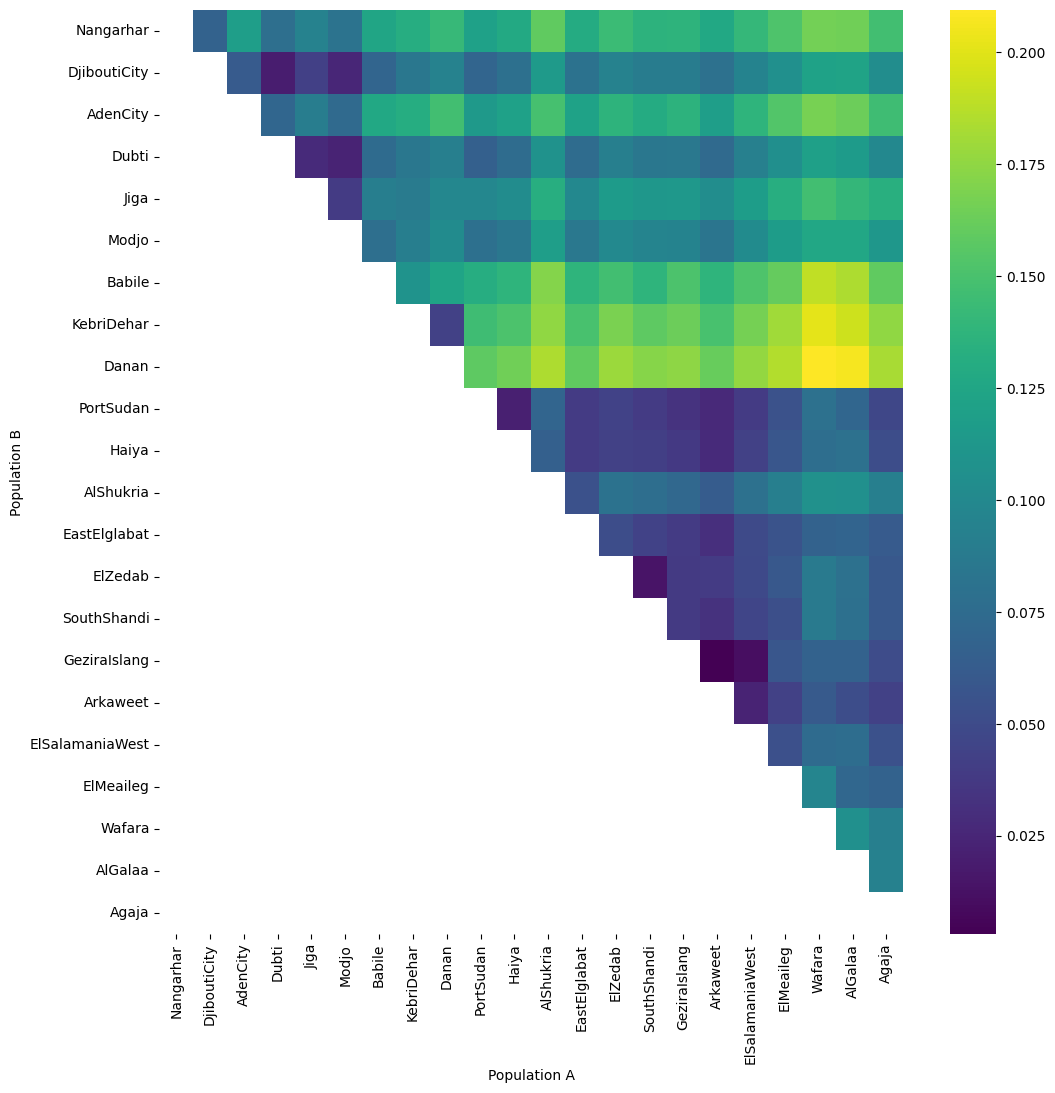

In [49]:
idx = sorted(set(sub['popa']).union(sub['popb']))

fst_widemat = (sub.pivot(index='popa', columns='popb', values='fst')
   .reindex(index=idx, columns=idx)
   .fillna(0, downcast='infer')
   .pipe(lambda x: x+x.values.T)
 )
reordered_df = fst_widemat.loc[locs, locs]

# Create a mask for the lower triangle
mask = np.tril(np.ones_like(reordered_df, dtype=bool))


# Plot the heatmap with the mask
# Plot the heatmap with the mask
plt.figure(figsize=(12, 12))
hm = sns.heatmap(
    reordered_df,
    mask=mask,
    cmap='viridis',  # Use viridis color palette
    #annot=True,
    cbar=True
)

# Customize axis labels
hm.set_xlabel('Population A')
hm.set_ylabel('Population B')

In [50]:
loc_df = df_samples.query('country != "Pakistan" & country != "Afghanistan" & country != "SaudiArabia" & country != "India"')

loc_df = loc_df[['location','latitude','longitude']].drop_duplicates()

In [51]:
#merge relatedness with metadata
from geopy.distance import geodesic as GD

df_samples
res_intermediate = pd.merge(sub, loc_df, left_on='popa', right_on='location')
res_combs = pd.merge(res_intermediate, loc_df, left_on='popb', right_on='location')
res_combs =  res_combs[(res_combs['popa'] != 'Nangarhar') & (res_combs['popb'] != 'Nangarhar')]
latcol = 'latitude'
longcol = 'longitude'

distlist = []
for i, row in res_combs.iterrows():
    lonlat1 = (row[str(longcol+'_x')], row[str(latcol+'_x')])
    lonlat2 = (row[str(longcol+'_y')], row[str(latcol+'_y')])
    dist = GD(lonlat1, lonlat2).m
    distlist.append(dist)
res_combs['dist'] = distlist
import plotly.express as px
px.scatter(res_combs, x='dist',y='fst')

In [39]:
res_combs.to_csv('~/Projects/AsGARD/data/fst_dist.csv')

In [ ]:
#Now let's see if fst increases linearly with distance from major port

res_combs['']

In [110]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

<Axes: >

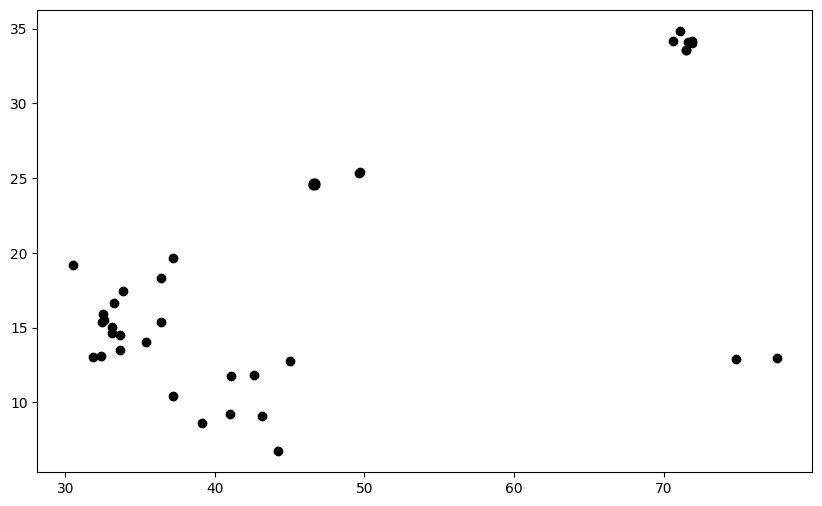

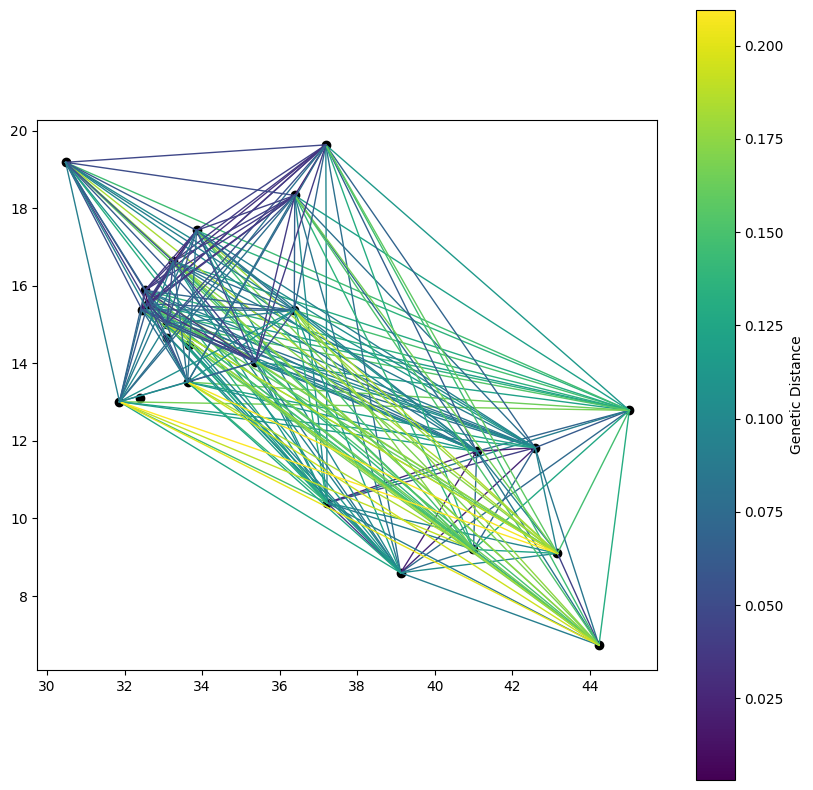

In [112]:
# Plot map with edges
fig, ax = plt.subplots(figsize=(10, 10))
locations.plot(ax=ax, color='black')  # Plot sampling locations

for (loc1, loc2, data) in G.edges(data=True):
    loc1_coords = locations[locations['location'] == loc1].geometry.values[0]
    loc2_coords = locations[locations['location'] == loc2].geometry.values[0]
    distance = data['weight']
    color = cmap(norm(distance))  # Map distance to color
    ax.plot([loc1_coords.x, loc2_coords.x], [loc1_coords.y, loc2_coords.y],
            color=color, linewidth=1)
    
# Add a colorbar for genetic distances
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Genetic Distance")

In [ ]:
#distance from nearest port
#distance from djibouti